<Figure size 432x288 with 0 Axes>

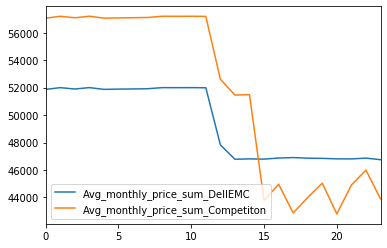

In [22]:
import pandas as pd
from sklearn import linear_model
import pyinform

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

dataset_dell = pd.read_excel('./input_data/time_series.xlsx', sheet_name='DellEMC_final')
dataset_dell['Vendor'] = 'DellEMC'

dataset_comp = pd.read_excel('./input_data/time_series.xlsx', sheet_name='Competition_final')
dataset_comp['Vendor'] = 'HPE'

dataset = dataset_dell.merge(dataset_comp, on='Date_PriceMonth', suffixes=('_DellEMC', '_Competiton'))

time_series = dataset[['Date_PriceMonth', 'Avg_monthly_price_sum_DellEMC', 'Avg_monthly_price_sum_Competiton']]

df = time_series[['Avg_monthly_price_sum_DellEMC', 'Avg_monthly_price_sum_Competiton']]
#with plt.xkcd():
#    plt.figure()
#    df.plot(legend=True)

plt.figure()
df.plot(legend=True)

<Figure size 432x288 with 0 Axes>

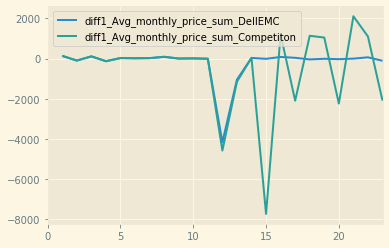

In [23]:

#Differencing to remove the trend
df_test = pd.DataFrame()
df_test['diff1_Avg_monthly_price_sum_DellEMC'] = df['Avg_monthly_price_sum_DellEMC'].diff()
df_test['diff1_Avg_monthly_price_sum_Competiton'] = df['Avg_monthly_price_sum_Competiton'].diff()

plt.style.use('Solarize_Light2')
plt.figure()
df_test[['diff1_Avg_monthly_price_sum_DellEMC', 'diff1_Avg_monthly_price_sum_Competiton']].plot(legend=True)

In [24]:
## Removing NaNs(because of differencing)
xs = list(df_test['diff1_Avg_monthly_price_sum_DellEMC'][1:])
ys = list(df_test['diff1_Avg_monthly_price_sum_Competiton'][1:])

gc_df = pd.DataFrame({'diff1_Avg_monthly_price_sum_DellEMC': df_test['diff1_Avg_monthly_price_sum_DellEMC'][1:],
                     'diff1_Avg_monthly_price_sum_Competiton': df_test['diff1_Avg_monthly_price_sum_Competiton'][1:]})
                      
gc_df.to_csv('gc.csv', index=False)

# Correlation

## plot 1: Cross-correlation
## plot 2: Auto-correlation of DellEMC
## plot 3: Auto-correlation of competitor

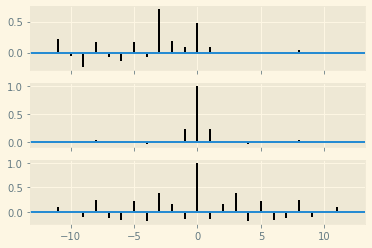

In [25]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True)
ax1.xcorr(xs, ys, usevlines=True, maxlags=12, normed=True, lw=2)
ax1.grid(True)

ax2.acorr(xs, usevlines=True, normed=True, maxlags=12, lw=2)
ax2.grid(True)

ax3.acorr(ys, usevlines=True, normed=True, maxlags=12, lw=2)
ax3.grid(True)

plt.show()

## Augmented Dickey Fuller test
### H0: Time series is non-stationary
### H1: Time series is stationary

In [26]:
import statsmodels.tsa.stattools as tsa

adf_results = {}
for col in df_test[1:].columns.values:  #or edit this for a subset of columns first
    adf_results[col] = tsa.adfuller(df_test[1:][col], autolag='BIC')
    
adf_results

{'diff1_Avg_monthly_price_sum_DellEMC': (-3.734815337805183,
  0.0036492587926169103,
  0,
  22,
  {'1%': -3.769732625845229,
   '5%': -3.005425537190083,
   '10%': -2.6425009917355373},
  224.31300673332944),
 'diff1_Avg_monthly_price_sum_Competiton': (-5.5798365708100635,
  1.4047878685891916e-06,
  0,
  22,
  {'1%': -3.769732625845229,
   '5%': -3.005425537190083,
   '10%': -2.6425009917355373},
  245.8586468171366)}

## Granger causality

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 3
test = 'ssr_chi2test'

granger_test_result = grangercausalitytests(gc_df[['diff1_Avg_monthly_price_sum_DellEMC', 'diff1_Avg_monthly_price_sum_Competiton']],
                                            maxlag=maxlag,
                                            verbose=True)
#granger_test_result


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0397  , p=0.8443  , df_denom=19, df_num=1
ssr based chi2 test:   chi2=0.0459  , p=0.8303  , df=1
likelihood ratio test: chi2=0.0459  , p=0.8304  , df=1
parameter F test:         F=0.0397  , p=0.8443  , df_denom=19, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0667  , p=0.9357  , df_denom=16, df_num=2
ssr based chi2 test:   chi2=0.1752  , p=0.9161  , df=2
likelihood ratio test: chi2=0.1745  , p=0.9165  , df=2
parameter F test:         F=0.0667  , p=0.9357  , df_denom=16, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0562  , p=0.9817  , df_denom=13, df_num=3
ssr based chi2 test:   chi2=0.2592  , p=0.9675  , df=3
likelihood ratio test: chi2=0.2575  , p=0.9678  , df=3
parameter F test:         F=0.0562  , p=0.9817  , df_denom=13, df_num=3


## Transfer entropy
### R loading

In [31]:
#%load_ext rpy2.ipython
#Uncomment the first line to load R extension.
%reload_ext rpy2.ipython

In [34]:
%%R
#Note that the output from R is being printed to the command prompt


install.packages("multispatialCCM")

library(readxl)
library(RTransferEntropy)
library(future)
library(multispatialCCM)

dataset <- read.csv('./gc.csv')

vector_dell <- dataset[['diff1_Avg_monthly_price_sum_DellEMC']]
vector_comp <- dataset[['diff1_Avg_monthly_price_sum_Competiton']]

In [36]:
%%R

shannon_te <- transfer_entropy(vector_dell, vector_comp)
shannon_te

In [8]:
#xs = list(df['Avg_monthly_price_sum_DellEMC'])
#ys = list(df['Avg_monthly_price_sum_Competiton'])

In [9]:
#ys = pyinform.utils.bin_series(ys, b=4)
#xs = pyinform.utils.bin_series(xs, b=4)
#list(pyinform.utils.coalesce_series(ys))

In [10]:
#ys

(array([2, 2, 2, 1, 1, 1, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3]), 4, 8020.650000000001)

In [11]:
#pyinform.transfer_entropy([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3,
#        2, 0], [2, 2, 2, 1, 1, 1, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
#        3, 3], k=2)

0.01253846671594508

In [15]:
#ys

(array([0, 0, 1, 1, 1, 1, 0, 0, 0]), 2)